In [1]:
# Cell 1: Setup
import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm

# Paths
FPV_MODEL = Path("/data/omar/RESEARCH/crosswalk-cctv/outputs/stage1_fpv/best_model.pth")
CCTV_DIR = Path("/data/omar/RESEARCH/crosswalk-cctv/data/cctv_frames")
OUTPUT_DIR = Path("/data/omar/RESEARCH/crosswalk-cctv/outputs/stage1_test_on_cctv")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Device: {device}")
print(f" FPV Model: {FPV_MODEL}")
print(f" CCTV Frames: {CCTV_DIR}")

 Device: cuda
 FPV Model: /data/omar/RESEARCH/crosswalk-cctv/outputs/stage1_fpv/best_model.pth
 CCTV Frames: /data/omar/RESEARCH/crosswalk-cctv/data/cctv_frames


In [2]:
# Cell 2: Load Model (same architecture from training)
class SimpleUNet(nn.Module):
    """Lightweight U-Net for crosswalk segmentation"""
    
    def __init__(self, in_channels=3, out_channels=1):
        super(SimpleUNet, self).__init__()
        
        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        
        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = self.conv_block(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = self.conv_block(128, 64)
        
        # Output
        self.out = nn.Conv2d(64, out_channels, 1)
        
        self.pool = nn.MaxPool2d(2)
        
    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        
        # Bottleneck
        b = self.bottleneck(self.pool(e4))
        
        # Decoder
        d4 = self.upconv4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)
        
        d3 = self.upconv3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.upconv2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        
        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        
        out = self.out(d1)
        return torch.sigmoid(out)

# Load model
print("  Loading FPV-trained model...")
model = SimpleUNet(in_channels=3, out_channels=1)
checkpoint = torch.load(FPV_MODEL, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

print(f" Model loaded! (Trained Val IoU: {checkpoint['val_iou']:.4f})")

  Loading FPV-trained model...
 Model loaded! (Trained Val IoU: 0.9244)


In [3]:
# Cell 3: Preprocessing Functions
import torchvision.transforms as T

# Same preprocessing as training
preprocess = T.Compose([
    T.ToTensor(),
    T.Resize((512, 512), antialias=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225])
])

def predict_on_image(model, img_path, device):
    """Run model on a single image"""
    # Load image
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    original_size = img_rgb.shape[:2]
    
    # Preprocess
    img_tensor = preprocess(img_rgb).unsqueeze(0).to(device)
    
    # Predict
    with torch.no_grad():
        pred = model(img_tensor)
    
    # Post-process
    pred = pred.squeeze().cpu().numpy()
    
    # Resize back to original
    pred_resized = cv2.resize(pred, (original_size[1], original_size[0]))
    
    return img_rgb, pred_resized

print(" Preprocessing ready!")

 Preprocessing ready!


In [4]:
# Cell 4: Test on ALL CCTV frames
print("="*60)
print(" TESTING FPV MODEL ON CCTV FRAMES")
print("="*60)
print()

# Get all CCTV frames
cctv_frames = sorted(list(CCTV_DIR.glob('*.jpg')))
print(f"Found {len(cctv_frames)} CCTV frames")
print()

# Predict on all
results = []

for img_path in tqdm(cctv_frames, desc="Testing"):
    img_rgb, pred = predict_on_image(model, img_path, device)
    
    # Calculate confidence (mean prediction value)
    confidence = pred.mean()
    max_confidence = pred.max()
    
    # Calculate brightness
    brightness = np.mean(cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY))
    
    results.append({
        'filename': img_path.name,
        'confidence': confidence,
        'max_confidence': max_confidence,
        'brightness': brightness,
        'prediction': pred,
        'image': img_rgb
    })

print(f"\n Tested on {len(results)} frames!")

 TESTING FPV MODEL ON CCTV FRAMES

Found 175 CCTV frames



Testing:   0%|          | 0/175 [00:00<?, ?it/s]


 Tested on 175 frames!


 ANALYSIS: FPV Model on CCTV

 Prediction Statistics:
   Mean confidence: 0.0438
   Std confidence:  0.1183
   Min confidence:  0.0005
   Max confidence:  0.4978

 Night frames: 104
   Mean confidence: 0.0016

  Day frames: 71
   Mean confidence: 0.1057



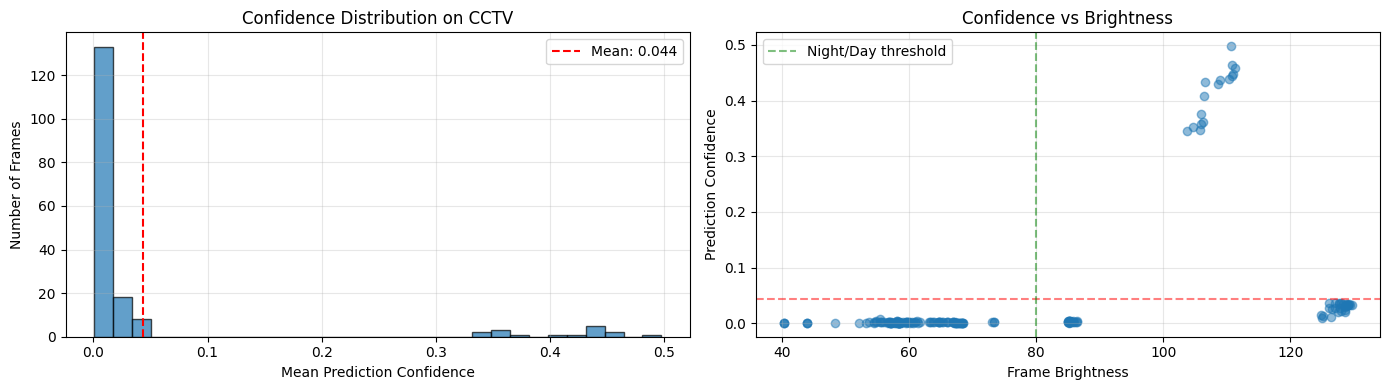

In [5]:
# Cell 5: Analyze Predictions
print("="*60)
print(" ANALYSIS: FPV Model on CCTV")
print("="*60)
print()

# Overall statistics
confidences = [r['confidence'] for r in results]
max_confidences = [r['max_confidence'] for r in results]
brightnesses = [r['brightness'] for r in results]

print(" Prediction Statistics:")
print(f"   Mean confidence: {np.mean(confidences):.4f}")
print(f"   Std confidence:  {np.std(confidences):.4f}")
print(f"   Min confidence:  {np.min(confidences):.4f}")
print(f"   Max confidence:  {np.max(confidences):.4f}")
print()

# Split by brightness (night vs day)
night_frames = [r for r in results if r['brightness'] < 80]
day_frames = [r for r in results if r['brightness'] >= 80]

print(f" Night frames: {len(night_frames)}")
print(f"   Mean confidence: {np.mean([r['confidence'] for r in night_frames]):.4f}")
print()

print(f"  Day frames: {len(day_frames)}")
print(f"   Mean confidence: {np.mean([r['confidence'] for r in day_frames]):.4f}")
print()

# Plot confidence distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].hist(confidences, bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Mean Prediction Confidence')
axes[0].set_ylabel('Number of Frames')
axes[0].set_title('Confidence Distribution on CCTV')
axes[0].axvline(np.mean(confidences), color='red', linestyle='--', label=f'Mean: {np.mean(confidences):.3f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].scatter(brightnesses, confidences, alpha=0.5)
axes[1].set_xlabel('Frame Brightness')
axes[1].set_ylabel('Prediction Confidence')
axes[1].set_title('Confidence vs Brightness')
axes[1].axhline(np.mean(confidences), color='red', linestyle='--', alpha=0.5)
axes[1].axvline(80, color='green', linestyle='--', alpha=0.5, label='Night/Day threshold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'cctv_confidence_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

 VISUALIZING PREDICTIONS

 BEST Predictions (Highest Confidence):


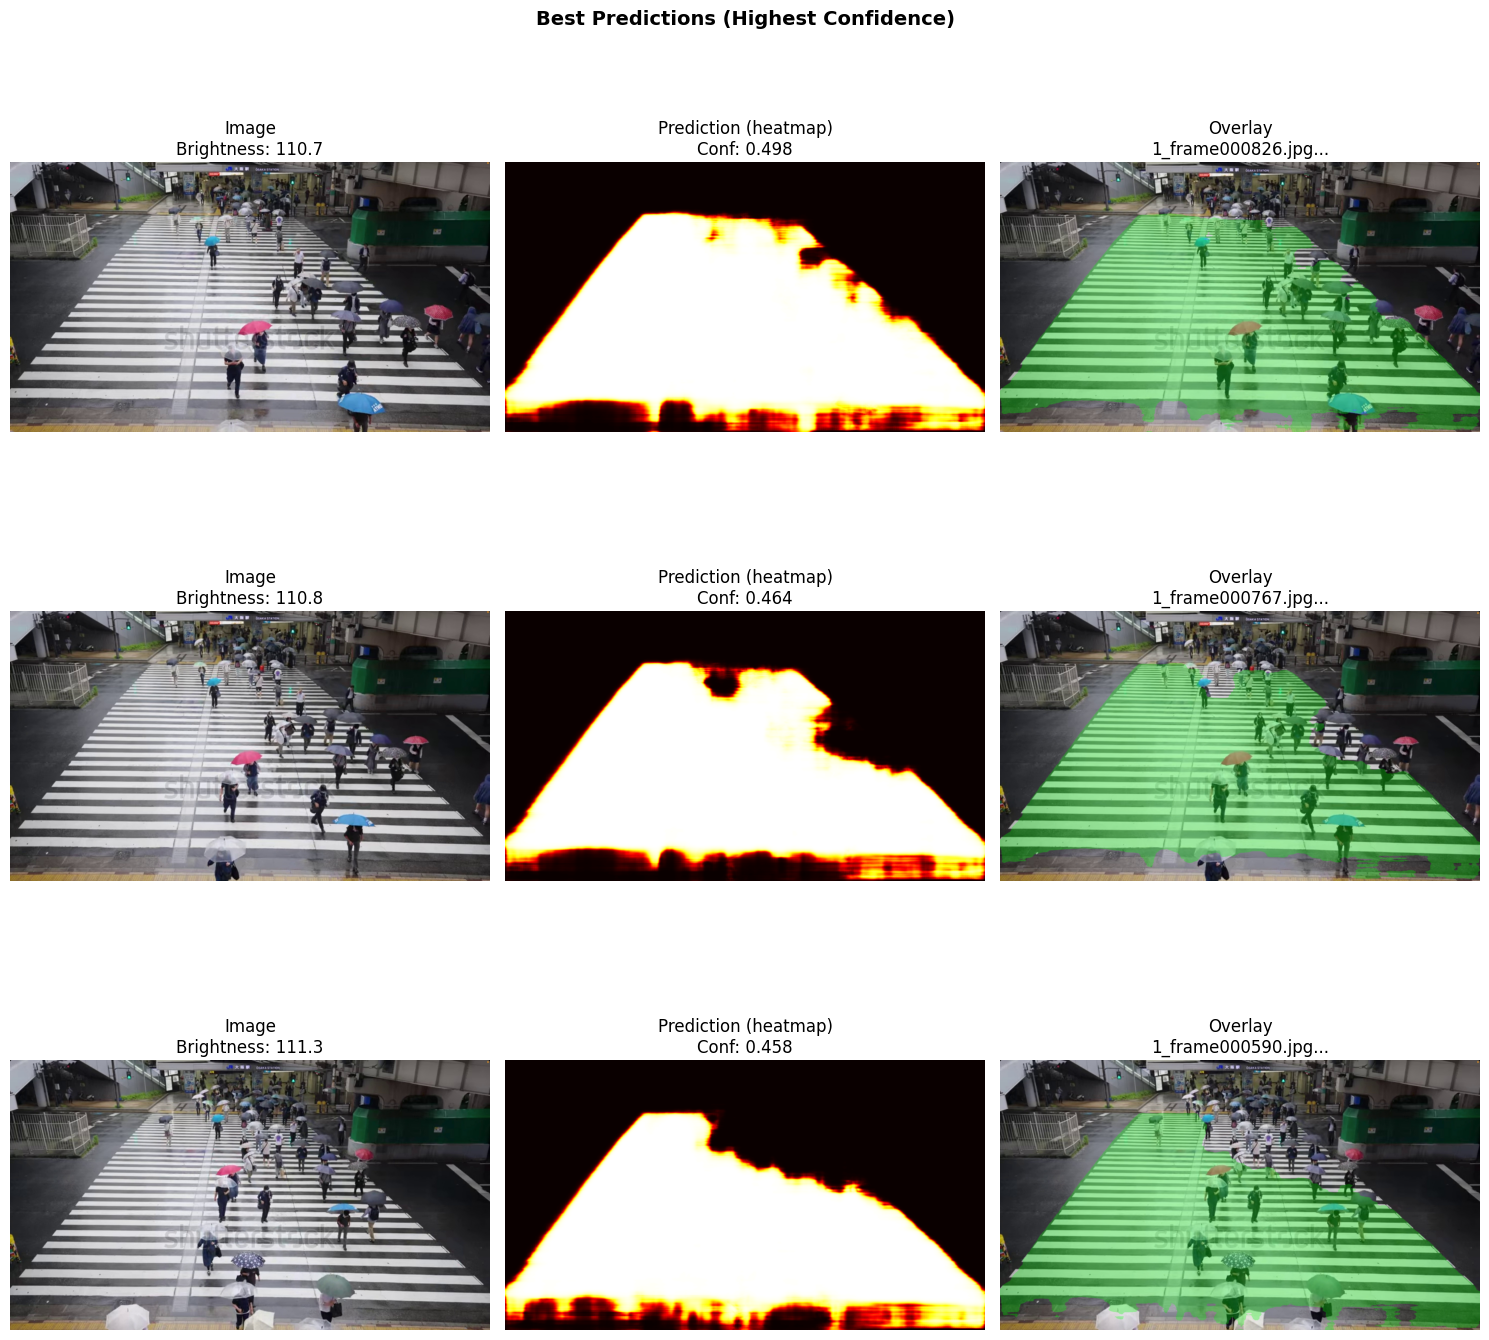


 WORST Predictions (Lowest Confidence):


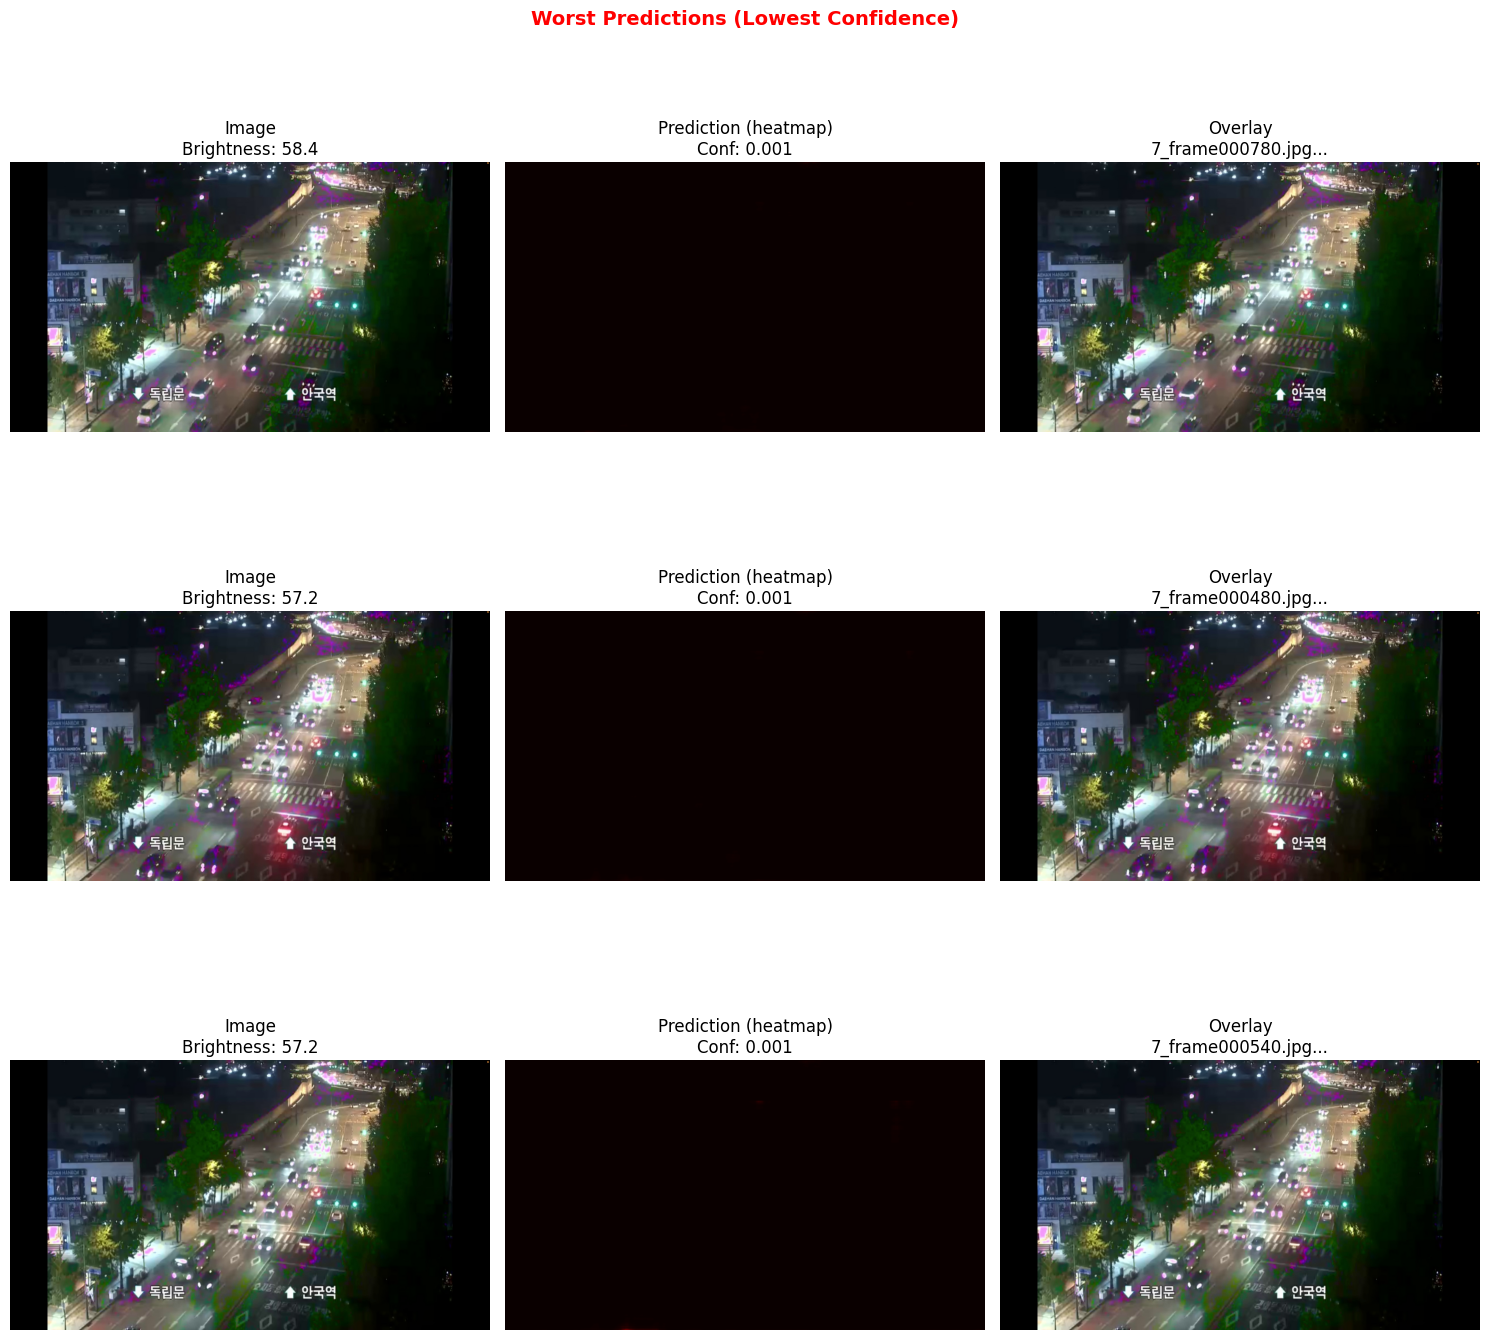

In [7]:
# Cell 6: Visualize Best & Worst Predictions
print("="*60)
print(" VISUALIZING PREDICTIONS")
print("="*60)
print()

# Sort by confidence
results_sorted = sorted(results, key=lambda x: x['confidence'], reverse=True)

# Best predictions (highest confidence)
print(" BEST Predictions (Highest Confidence):")
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i in range(3):
    r = results_sorted[i]
    
    # Image
    axes[i, 0].imshow(r['image'])
    axes[i, 0].set_title(f"Image\nBrightness: {r['brightness']:.1f}")
    axes[i, 0].axis('off')
    
    # Prediction (heatmap)
    axes[i, 1].imshow(r['prediction'], cmap='hot', vmin=0, vmax=1)
    axes[i, 1].set_title(f"Prediction (heatmap)\nConf: {r['confidence']:.3f}")
    axes[i, 1].axis('off')
    
    # Overlay
    pred_binary = (r['prediction'] > 0.5).astype(np.uint8) * 255
    overlay = r['image'].copy()
    overlay[pred_binary > 127] = [0, 255, 0]
    blended = cv2.addWeighted(r['image'], 0.7, overlay, 0.3, 0)
    
    axes[i, 2].imshow(blended)
    axes[i, 2].set_title(f"Overlay\n{r['filename'][:20]}...")
    axes[i, 2].axis('off')

plt.suptitle("Best Predictions (Highest Confidence)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'best_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

# Worst predictions (lowest confidence)
print("\n WORST Predictions (Lowest Confidence):")
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i in range(3):
    r = results_sorted[-(i+1)]  # Start from end
    
    axes[i, 0].imshow(r['image'])
    axes[i, 0].set_title(f"Image\nBrightness: {r['brightness']:.1f}")
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(r['prediction'], cmap='hot', vmin=0, vmax=1)
    axes[i, 1].set_title(f"Prediction (heatmap)\nConf: {r['confidence']:.3f}")
    axes[i, 1].axis('off')
    
    pred_binary = (r['prediction'] > 0.5).astype(np.uint8) * 255
    overlay = r['image'].copy()
    overlay[pred_binary > 127] = [0, 255, 0]
    blended = cv2.addWeighted(r['image'], 0.7, overlay, 0.3, 0)
    
    axes[i, 2].imshow(blended)
    axes[i, 2].set_title(f"Overlay\n{r['filename'][:20]}...")
    axes[i, 2].axis('off')

plt.suptitle("Worst Predictions (Lowest Confidence)", fontsize=14, fontweight='bold', color='red')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'worst_predictions.png', dpi=150, bbox_inches='tight')
plt.show()


 Random Sample of CCTV Predictions:


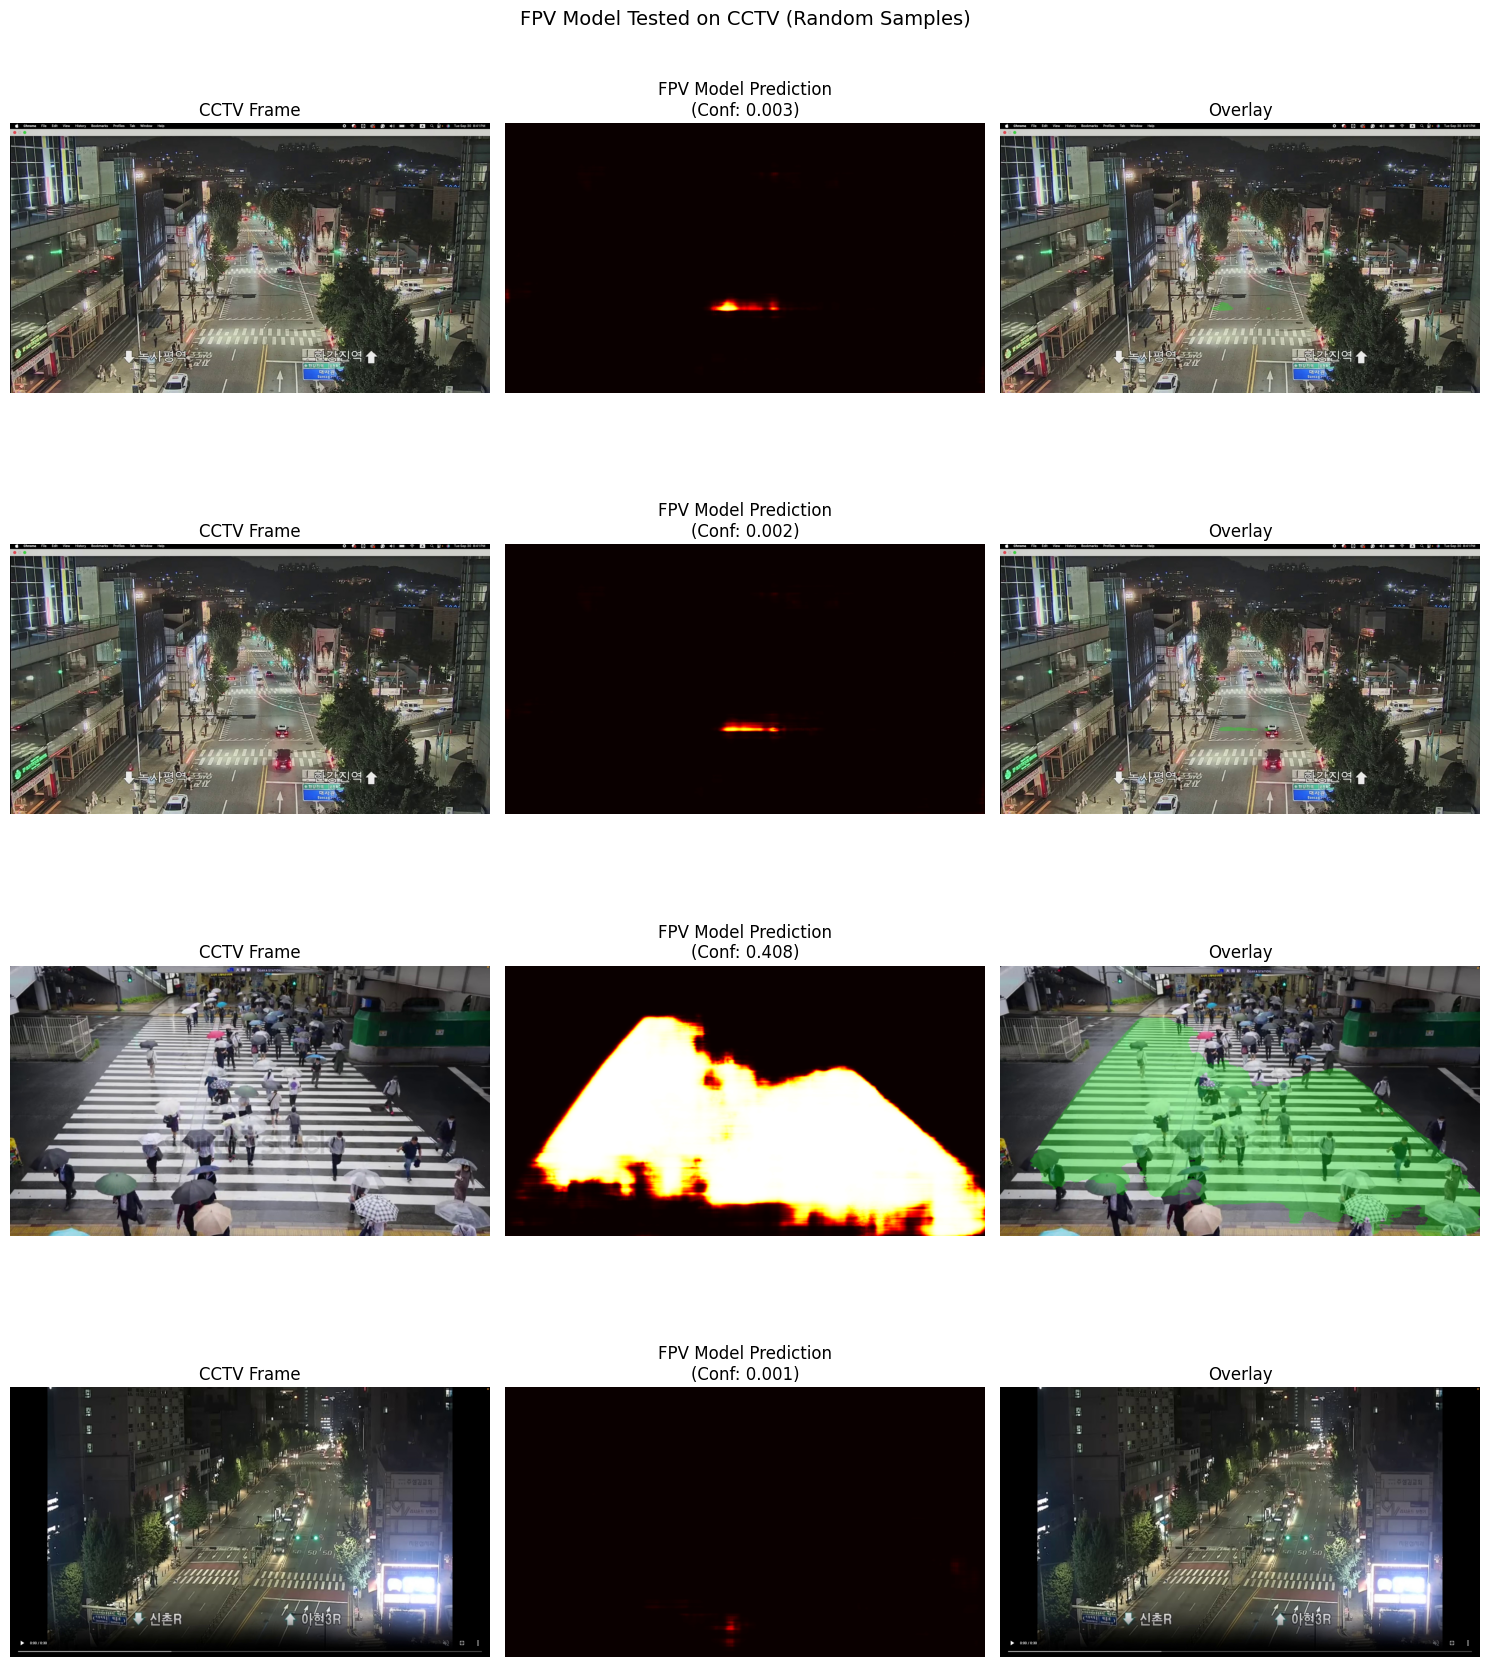

In [8]:
# Cell 7: Random Sample Visualization
print()
print(" Random Sample of CCTV Predictions:")

fig, axes = plt.subplots(4, 3, figsize=(15, 18))

random_indices = np.random.choice(len(results), 4, replace=False)

for i, idx in enumerate(random_indices):
    r = results[idx]
    
    axes[i, 0].imshow(r['image'])
    axes[i, 0].set_title(f"CCTV Frame")
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(r['prediction'], cmap='hot', vmin=0, vmax=1)
    axes[i, 1].set_title(f"FPV Model Prediction\n(Conf: {r['confidence']:.3f})")
    axes[i, 1].axis('off')
    
    pred_binary = (r['prediction'] > 0.5).astype(np.uint8) * 255
    overlay = r['image'].copy()
    overlay[pred_binary > 127] = [0, 255, 0]
    blended = cv2.addWeighted(r['image'], 0.7, overlay, 0.3, 0)
    
    axes[i, 2].imshow(blended)
    axes[i, 2].set_title("Overlay")
    axes[i, 2].axis('off')

plt.suptitle("FPV Model Tested on CCTV (Random Samples)", fontsize=14)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'random_samples.png', dpi=150, bbox_inches='tight')
plt.show()


 THE DOMAIN GAP



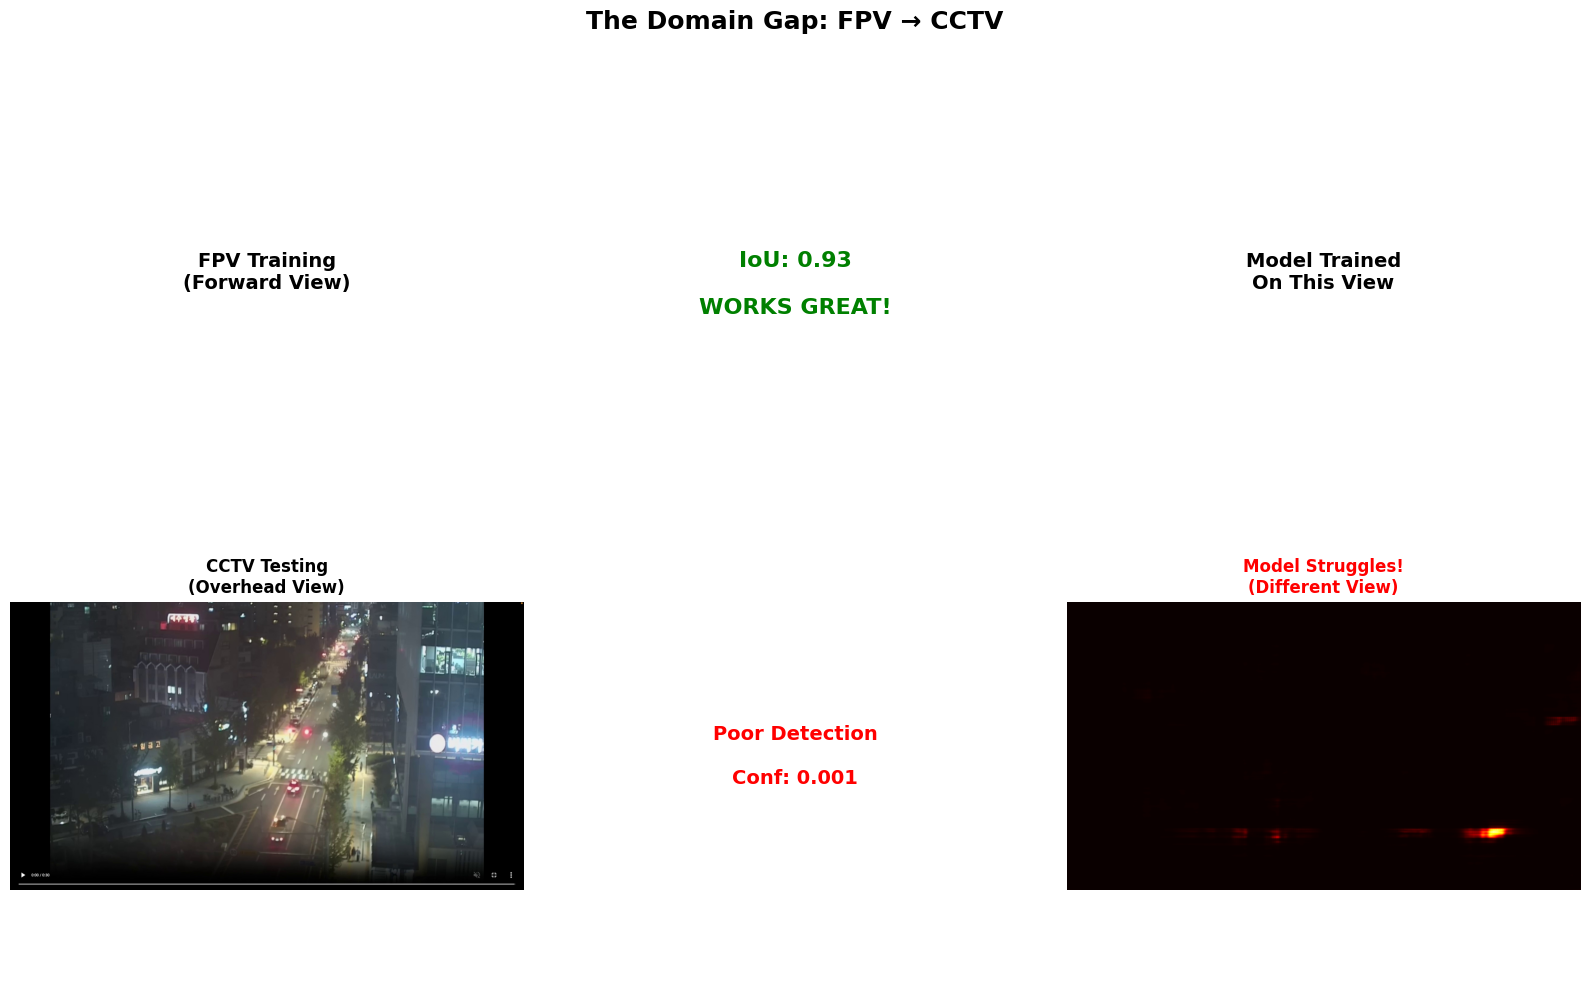

 FPV Model on FPV Test Data: IoU = 0.93
 FPV Model on CCTV Data: Confidence = 0.044

💡 THIS IS WHY WE NEED STAGE 2 (GEOMETRIC ADAPTATION)!


In [9]:
# Cell 8: THE DOMAIN GAP VISUALIZATION
print()
print("="*60)
print(" THE DOMAIN GAP")
print("="*60)
print()

fig = plt.figure(figsize=(16, 10))

# FPV Training Sample (from your test results image)
ax1 = plt.subplot(2, 3, 1)
ax1.text(0.5, 0.5, "FPV Training\n(Forward View)", 
         ha='center', va='center', fontsize=14, fontweight='bold')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.axis('off')

ax2 = plt.subplot(2, 3, 2)
ax2.text(0.5, 0.5, "\nIoU: 0.93\n\nWORKS GREAT!", 
         ha='center', va='center', fontsize=16, fontweight='bold', color='green')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.axis('off')

ax3 = plt.subplot(2, 3, 3)
ax3.text(0.5, 0.5, "Model Trained\nOn This View", 
         ha='center', va='center', fontsize=14, fontweight='bold')
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)
ax3.axis('off')

# CCTV Testing (show actual result)
ax4 = plt.subplot(2, 3, 4)
# Pick a CCTV sample
sample_idx = len(results) // 2
ax4.imshow(results[sample_idx]['image'])
ax4.set_title("CCTV Testing\n(Overhead View)", fontweight='bold')
ax4.axis('off')

ax5 = plt.subplot(2, 3, 5)
conf_status = results[sample_idx]['confidence']
if conf_status > 0.4:
    status = "\nPartial Detection"
    color = 'orange'
else:
    status = "\nPoor Detection"
    color = 'red'
    
ax5.text(0.5, 0.5, f"{status}\n\nConf: {conf_status:.3f}", 
         ha='center', va='center', fontsize=14, fontweight='bold', color=color)
ax5.set_xlim(0, 1)
ax5.set_ylim(0, 1)
ax5.axis('off')

ax6 = plt.subplot(2, 3, 6)
ax6.imshow(results[sample_idx]['prediction'], cmap='hot')
ax6.set_title("Model Struggles!\n(Different View)", fontweight='bold', color='red')
ax6.axis('off')

plt.suptitle("The Domain Gap: FPV → CCTV", fontsize=18, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'domain_gap_visualization.png', dpi=150, bbox_inches='tight')
plt.show()

print(f" FPV Model on FPV Test Data: IoU = 0.93")
print(f" FPV Model on CCTV Data: Confidence = {np.mean(confidences):.3f}")
print()
print("💡 THIS IS WHY WE NEED STAGE 2 (GEOMETRIC ADAPTATION)!")

In [10]:
# Cell 9: Summary & Save Results
import json

summary = {
    'num_cctv_frames': len(results),
    'mean_confidence': float(np.mean(confidences)),
    'std_confidence': float(np.std(confidences)),
    'night_frames': len(night_frames),
    'day_frames': len(day_frames),
    'night_mean_conf': float(np.mean([r['confidence'] for r in night_frames])) if night_frames else 0,
    'day_mean_conf': float(np.mean([r['confidence'] for r in day_frames])) if day_frames else 0,
}

with open(OUTPUT_DIR / 'cctv_test_results.json', 'w') as f:
    json.dump(summary, f, indent=2)

print()
print("="*60)
print(" SUMMARY: FPV MODEL ON CCTV")
print("="*60)
print()
print(f"FPV Model Performance:")
print(f"   On FPV test data: IoU = 0.9305")
print(f"   On CCTV data: Mean Conf = {summary['mean_confidence']:.4f}")
print()
print(f"CCTV Breakdown:")
print(f"   Night frames ({len(night_frames)}): Conf = {summary['night_mean_conf']:.4f}")
print(f"    Day frames ({len(day_frames)}): Conf = {summary['day_mean_conf']:.4f}")
print()
print("="*60)
print(" KEY INSIGHT:")
print("="*60)
print("The model trained on FPV (forward view) struggles on CCTV (overhead)!")
print("This PROVES the domain gap and MOTIVATES our geometric adaptation approach.")
print()
print(" Results saved to:", OUTPUT_DIR)


 SUMMARY: FPV MODEL ON CCTV

FPV Model Performance:
   On FPV test data: IoU = 0.9305
   On CCTV data: Mean Conf = 0.0438

CCTV Breakdown:
   Night frames (104): Conf = 0.0016
    Day frames (71): Conf = 0.1057

 KEY INSIGHT:
The model trained on FPV (forward view) struggles on CCTV (overhead)!
This PROVES the domain gap and MOTIVATES our geometric adaptation approach.

 Results saved to: /data/omar/RESEARCH/crosswalk-cctv/outputs/stage1_test_on_cctv


 TESTING ON SPECIFIC FRAME

 Testing frame: 8_frame000405.jpg

 Prediction Statistics:
   Mean confidence:  0.0337
   Max confidence:   0.9975
   Brightness:       127.7 (Day)
   Coverage:         3.08% of image



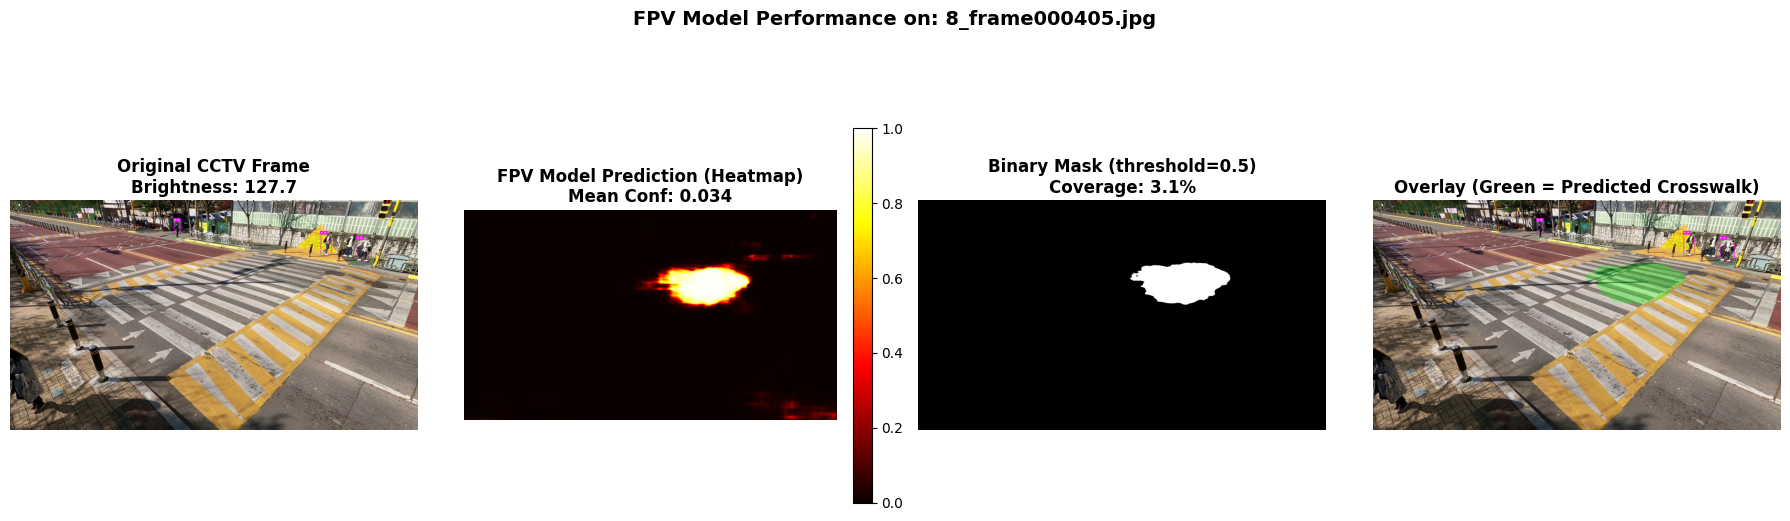

 ANALYSIS

 POOR DETECTION:
   The model barely detects anything.
   Clear evidence of domain gap (FPV → CCTV).

💡 KEY OBSERVATIONS:
   • Very low coverage - model is too conservative
   • Only 2.8% pixels have high confidence
   • Bright frame (day) - better lighting but still viewpoint issue

 FOR COMPARISON:
   FPV Test Set IoU: 0.9305 (93%)
   This CCTV Frame:  0.0337 (3.4%)

 Performance drop: ~89.7 percentage points

 THIS IS WHY WE NEED GEOMETRIC ADAPTATION!
The FPV-trained model struggles on CCTV due to:
  1. Different viewpoint (forward → overhead)
  2. Different perspective (stripes look like trapezoids)
  3. Possibly different lighting conditions

 Next: Stage 2 will use ZEBRA STRIPE GEOMETRY
   to help the model adapt WITHOUT manual CCTV labels!


In [12]:
# Cell 10: Test on Specific CCTV Frame
print("="*60)
print(" TESTING ON SPECIFIC FRAME")
print("="*60)
print()

# Load the specific frame
specific_frame = Path("/data/omar/RESEARCH/crosswalk-cctv/data/cctv_frames/8_frame000405.jpg")

if not specific_frame.exists():
    print(f" Frame not found: {specific_frame}")
else:
    print(f" Testing frame: {specific_frame.name}")
    print()
    
    # Run prediction
    img_rgb, pred = predict_on_image(model, specific_frame, device)
    
    # Calculate metrics
    confidence = pred.mean()
    max_confidence = pred.max()
    brightness = np.mean(cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY))
    
    # Create binary mask
    pred_binary = (pred > 0.5).astype(np.uint8) * 255
    
    # Calculate coverage
    coverage = (pred_binary > 127).sum() / pred_binary.size * 100
    
    print(f" Prediction Statistics:")
    print(f"   Mean confidence:  {confidence:.4f}")
    print(f"   Max confidence:   {max_confidence:.4f}")
    print(f"   Brightness:       {brightness:.1f} ({'Night' if brightness < 80 else 'Day'})")
    print(f"   Coverage:         {coverage:.2f}% of image")
    print()
    
    # Visualize
    fig = plt.figure(figsize=(18, 6))
    
    # Original image
    ax1 = plt.subplot(1, 4, 1)
    ax1.imshow(img_rgb)
    ax1.set_title(f"Original CCTV Frame\nBrightness: {brightness:.1f}", fontsize=12, fontweight='bold')
    ax1.axis('off')
    
    # Prediction heatmap
    ax2 = plt.subplot(1, 4, 2)
    im = ax2.imshow(pred, cmap='hot', vmin=0, vmax=1)
    ax2.set_title(f"FPV Model Prediction (Heatmap)\nMean Conf: {confidence:.3f}", fontsize=12, fontweight='bold')
    ax2.axis('off')
    plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
    
    # Binary mask
    ax3 = plt.subplot(1, 4, 3)
    ax3.imshow(pred_binary, cmap='gray')
    ax3.set_title(f"Binary Mask (threshold=0.5)\nCoverage: {coverage:.1f}%", fontsize=12, fontweight='bold')
    ax3.axis('off')
    
    # Overlay
    ax4 = plt.subplot(1, 4, 4)
    overlay = img_rgb.copy()
    overlay[pred_binary > 127] = [0, 255, 0]  # Green where predicted
    blended = cv2.addWeighted(img_rgb, 0.7, overlay, 0.3, 0)
    ax4.imshow(blended)
    ax4.set_title(f"Overlay (Green = Predicted Crosswalk)", fontsize=12, fontweight='bold')
    ax4.axis('off')
    
    plt.suptitle(f"FPV Model Performance on: {specific_frame.name}", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / f'specific_frame_{specific_frame.stem}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Analysis
    print("="*60)
    print(" ANALYSIS")
    print("="*60)
    print()
    
    if confidence > 0.5:
        print(" GOOD DETECTION:")
        print("   The model is fairly confident about the crosswalk location.")
        print("   This might be a well-lit, clear view that resembles FPV training data.")
    elif confidence > 0.3:
        print("  PARTIAL DETECTION:")
        print("   The model detects something but isn't very confident.")
        print("   Likely struggling with the overhead viewpoint.")
    else:
        print(" POOR DETECTION:")
        print("   The model barely detects anything.")
        print("   Clear evidence of domain gap (FPV → CCTV).")
    
    print()
    print("💡 KEY OBSERVATIONS:")
    
    # Check if it's detecting the right area
    if coverage > 30:
        print("   • High coverage - model might be over-predicting")
    elif coverage < 5:
        print("   • Very low coverage - model is too conservative")
    else:
        print("   • Reasonable coverage")
    
    # Check confidence distribution
    high_conf_pixels = (pred > 0.7).sum() / pred.size * 100
    if high_conf_pixels > 10:
        print(f"   • {high_conf_pixels:.1f}% pixels have high confidence (>0.7)")
    else:
        print(f"   • Only {high_conf_pixels:.1f}% pixels have high confidence")
    
    # Brightness factor
    if brightness < 80:
        print("   • Dark frame (night) - model trained mostly on brighter FPV data")
    else:
        print("   • Bright frame (day) - better lighting but still viewpoint issue")
    
    print()
    print(" FOR COMPARISON:")
    print(f"   FPV Test Set IoU: 0.9305 (93%)")
    print(f"   This CCTV Frame:  {confidence:.4f} ({confidence*100:.1f}%)")
    print()
    print(" Performance drop: ~{:.1f} percentage points".format((0.9305 - confidence) * 100))
    
    print()
    print("="*60)
    print(" THIS IS WHY WE NEED GEOMETRIC ADAPTATION!")
    print("="*60)
    print("The FPV-trained model struggles on CCTV due to:")
    print("  1. Different viewpoint (forward → overhead)")
    print("  2. Different perspective (stripes look like trapezoids)")
    print("  3. Possibly different lighting conditions")
    print()
    print(" Next: Stage 2 will use ZEBRA STRIPE GEOMETRY")
    print("   to help the model adapt WITHOUT manual CCTV labels!")